# Homework 4

In this colab, we use a dataset of colored shapes.

<img src="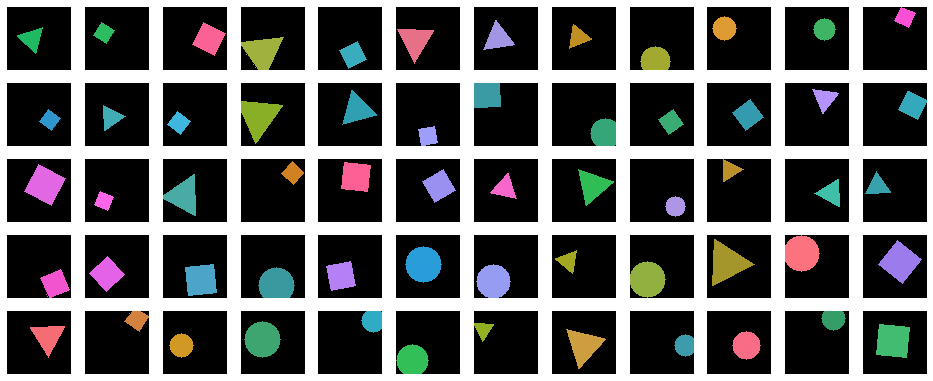
">

Each image has resolution $64 \times 64$. Across the dataset, there are three underlying varying factors:

+ Shape 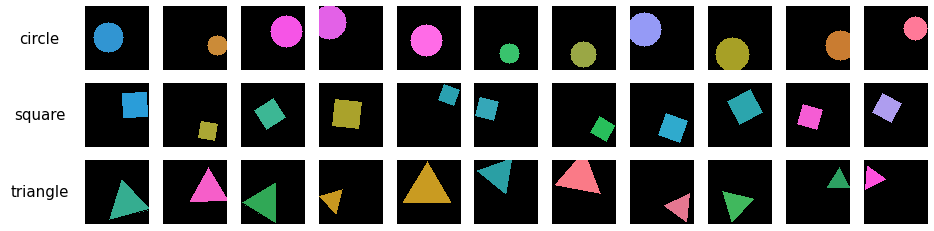
+ Color 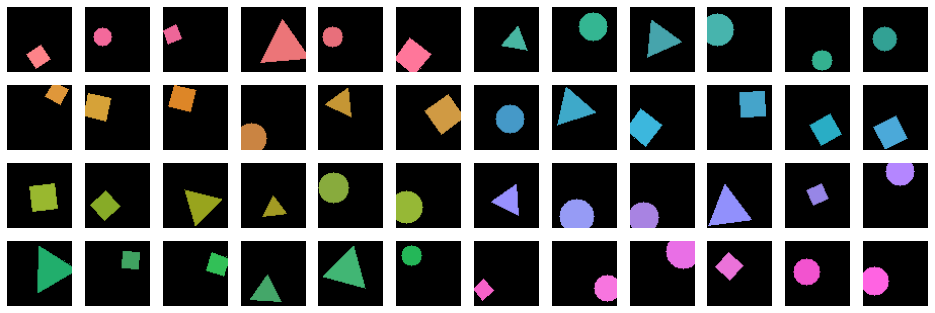
+ Location <img src="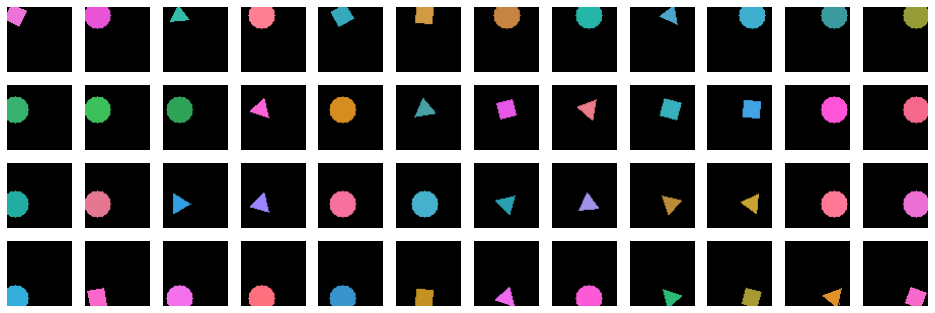
">

Without using any labelled information about these factors, we train autoencoders and contrastive encoders on this dataset, and evaluate the resulting latent spaces via nearest neighbor classification to test the encoders learn to capture these factors.

**NOTE:** Most of the code are provided in this colab. You are not required to fully read through the implementation of them, but should conceptually understand what the functions/classes with **docstrings** are doing.

In [1]:
from typing import *
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import contextlib

import torch
from torch import nn, optim
from torch.nn import functional as F

device = torch.device('cuda:0')
assert torch.cuda.is_available()

import torchvision
from IPython import display
from PIL import Image

from tqdm.auto import tqdm

/mnt/align3_drive/adrianoh/miniconda3/envs/dl-pset3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
# load data

data = np.load('/mnt/align3_drive/adrianoh/dl-pset4/content/shapes_dataset_6s898.npy', allow_pickle=True).item()
train_indices, val_indices = torch.arange(data['imgs'].shape[0]).split([64000 - 24000, 24000])


class Dataset:
    r'''
    Our dataset object for loading shapes dataset.
    '''

    def __init__(self, split: str, transform=None, num_samples: int = 1):
        r'''
        split (str): Whether to load training of validation images. Should be 'train' or 'val'.
        transform: Transformations on raw data, e.g., augmentations and/or normalization.
                   `to_tensor` and normalization is called automatically.
                   No need to explicitly pass in `ToTensor()` or `Normalize()`.
        num_samples (int):Number of transformed versions to return for each sample.
                           For autoencoder, this is 1. For contrastive, this is 2.
        '''
        self.split = split
        if split == 'train':
            self.indices = train_indices
        else:
            assert split == 'val'
            self.indices = val_indices
        self.num_samples = num_samples
        if transform is None:
            transform = lambda x: x
        self.transform = transform

    def get_augs(self, idx, num_samples):
        img = torchvision.transforms.functional.to_tensor(data['imgs'][self.indices[idx]])
        return tuple(self.transform(img).clamp(0, 1) for _ in range(num_samples))

    def __getitem__(self, idx):
        r'''
        Fetech the data at index `idx`
        '''
        return tuple(tensor.sub(0.5).div(0.5) for tensor in self.get_augs(idx, num_samples=self.num_samples))

    def visualize(self, idx, num_samples=None):
        r'''
        Visualize the image at index `idx` for `num_samples` times (default to `self.num_samples`).

        These samples will be different if `self.transform` is random.
        '''
        if num_samples is None:
            num_samples = self.num_samples
        f, axs = plt.subplots(1, num_samples, figsize=(1.2 * num_samples, 1.4))
        if num_samples == 1:
            axs = [axs]
        else:
            axs = axs.reshape(-1)
        for ax, tensor in zip(axs, self.get_augs(idx, num_samples)):
            ax.axis('off')
            ax.imshow(tensor.permute(1, 2, 0))
        title = f'{self.split} dataset[{idx}]'
        if num_samples > 1:
            title += f'  ({num_samples} samples)'
        f.suptitle(title, fontsize=17, y=0.98)
        f.tight_layout(rect=[0, 0.03, 1, 0.9])
        return f

    def __len__(self):
        return self.indices.shape[0]

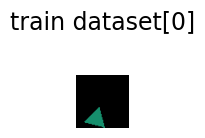

In [3]:
# Visualize

dataset = Dataset('train')
_ = dataset.visualize(0)

# Network architectures

Our encoder and decoder networks are standard CNNs! You should have no issues understand the following code.

In [4]:
# encoder architecture
class Encoder(nn.Module):
    def __init__(self, latent_dim, normalize: bool = False):
        r'''
        latent_dim (int): Dimension of latent space
        normalize (bool): Whether to restrict the output latent onto the unit hypersphere
        '''
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1) # 64x64 --> 32x32
        self.conv2 = nn.Conv2d(32, 32*2, 4, stride=2, padding=1) # 32x32 --> 16x16
        self.conv3 = nn.Conv2d(32*2, 32*4, 4, stride=2, padding=1) # 16x16 --> 8x8
        self.conv4 = nn.Conv2d(32*4, 32*8, 4, stride=2, padding=1) # 8x8 --> 4x4
        self.conv5 = nn.Conv2d(32*8, 32*16, 4, stride=2, padding=1) # 4x4 --> 2x2
        self.conv6 = nn.Conv2d(32*16, latent_dim, 4, stride=2, padding=1) # 2x2 --> 1x1
        self.fc = nn.Linear(latent_dim, latent_dim)

        self.nonlinearity = nn.ReLU()
        self.normalize = normalize

    def forward(self, x):
        x = self.nonlinearity(self.conv1(x))
        x = self.nonlinearity(self.conv2(x))
        x = self.nonlinearity(self.conv3(x))
        x = self.nonlinearity(self.conv4(x))
        x = self.nonlinearity(self.conv5(x))
        x = self.nonlinearity(self.conv6(x).flatten(1))
        x = self.fc(x)
        if self.normalize:
            x = F.normalize(x)
        return x

    def extra_repr(self):
        return f'normalize={self.normalize}'


# decoder architecture
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        r'''
        latent_dim (int): Dimension of latent space
        '''
        super(Decoder, self).__init__()

        self.conv1 = nn.ConvTranspose2d(latent_dim, 32*16, 4, stride=2, padding=1) # 1x1 --> 2x2
        self.conv2 = nn.ConvTranspose2d(32*16, 32*8, 4, stride=2, padding=1) # 2x2 --> 4x4
        self.conv3 = nn.ConvTranspose2d(32*8, 32*4, 4, stride=2, padding=1) # 4x4 --> 8x8
        self.conv4 = nn.ConvTranspose2d(32*4, 32*2, 4, stride=2, padding=1) # 8x8 --> 16x16
        self.conv5 = nn.ConvTranspose2d(32*2, 32, 4, stride=2, padding=1) # 16x16 --> 32x32
        self.conv6 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1) # 32x32 --> 64x64
        self.nonlinearity = nn.ReLU()

    def forward(self, z):
        z = z[..., None, None]  # make it convolution-friendly

        x = self.nonlinearity(self.conv1(z))
        x = self.nonlinearity(self.conv2(x))
        x = self.nonlinearity(self.conv3(x))
        x = self.nonlinearity(self.conv4(x))
        x = self.nonlinearity(self.conv5(x))
        return self.conv6(x)

# Nearest Neighbor Visualization

We provide a function `nn_visualize` that visualizes an encoder's embedding by plotting the nearest neighbors.  In particular, for an  input image, we plot the images that are closest to them in the feature space. By looking at them, we can understand what images the encoder considers similar (i.e., having low feature space distance).

There is no need to fully understand the code, but please look at the random encoder visualization below and make sure you understand what each image in the plot means.

In [5]:
@torch.no_grad()
def get_features(dataset: Dataset, encoder: Encoder, firstk: Optional[int] = None):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, pin_memory=True)
    n = 0
    features = []
    for batches in dataloader:
        batch = batches[0]
        features.append(encoder(batch.to(device)))
        n += batch.shape[0]
        if firstk is not None and n >= firstk:
            break
    features = torch.cat(features)
    if firstk is not None:
        features = features[:firstk]
    return features

@torch.no_grad()
def nn_visualize(dataset: Dataset, encoder: Encoder, num_nn: int = 10, desc: str = ''):
    r'''
    For a given `dataset` object, visualize `encoder` by nearest neighbors.

    In particular, the function takes `8` samples from `dataset`, computes
    their `num_nn` nearest neighbor samples (w.r.t. l2 embedding distance induced by
    `encoder`), and produces a plot.

    `desc` is a string description that is used to set the title of the plot.
    '''
    all_features = get_features(dataset, encoder, firstk=24000)
    source_feat = all_features[:8]
    dists = (source_feat[:, None] - all_features).pow(2).sum(-1)
    knns = torch.topk(dists, num_nn, dim=-1, largest=False).indices.cpu()

    nrow = knns.shape[0]
    ncol = num_nn + 2
    f, axes = plt.subplots(nrow, ncol, figsize=(ncol * 1, nrow * 1.1 + 1))
    for ax in axes.reshape(-1):
        ax.axis('off')

    axes[0, 0].set_title('Input Image', fontsize=15)

    for ax, imidx in zip(axes[:, 0], dataset.indices):
        ax.imshow(data['imgs'][imidx])

    for j in range(2, ncol):
        axes[0, j].set_title(f'NN {1 +j-2}', fontsize=15)

    for i in range(nrow):
        for j in range(2, ncol):
            axes[i, j].imshow(data['imgs'][dataset.indices[knns[i, j - 2]]])

    f.suptitle(f'{desc} Nesrest Neighbors (NNs) on {dataset.split.capitalize()} Set \n(near -> far, NN 1 is closest)', fontsize=20, y=0.98)
    f.tight_layout(rect=[0, 0.03, 1, 0.9])
    f.subplots_adjust(wspace=0.05, hspace=0.1)
    f.show()

The function visualizes a latent space by plotting nearest neighbors (right columns) for each of 8 input images (left column).

Here is an example output for **randomly assigned features**:

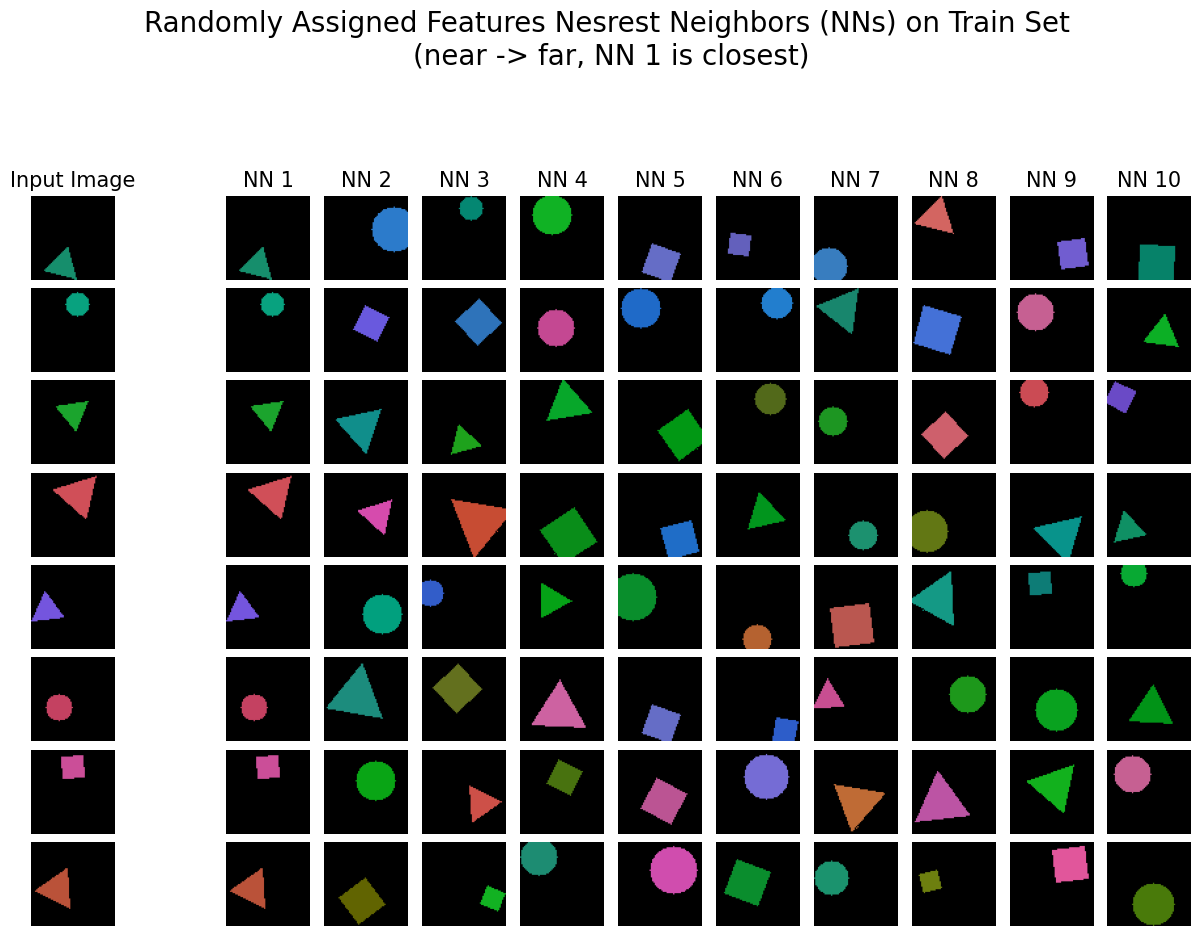

In [6]:
nn_visualize(
    dataset=Dataset('train'),
    encoder=lambda batch: torch.randn(batch.shape[0], 128, device=device),
    desc='Randomly Assigned Features',
)

# Autoencoder

**Question 7b:** **Understand** the provided code in `train_autoencoder`. Implement the FIXME that computes MSE reconstruction loss within 5 lines of code. Attach your code to write-up.

In [7]:
def train_autoencoder(latent_dim: int):
    r'''
    Train encoder and decoder networks with `latent_dim` latent dimensions according
    to the autoencoder objective (i.e., MSE reconstruction).

    Returns the trained encoder and decoder.
    '''
    enc = Encoder(latent_dim).to(device)
    dec = Decoder(latent_dim).to(device)

    optim = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=2e-4)

    dataset = Dataset('train')
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, pin_memory=True)
    num_epochs = 30

    for epoch in tqdm(range(num_epochs), desc=f'{num_epochs} epochs total'):
        for batch, in dataloader:
            batch = batch.to(device)
            # batch: a batched image tensor of shape [B x 3 x 64 x 64]
            
            # FIXED
            loss = torch.nn.functional.mse_loss(dec(enc(batch)), batch)

            optim.zero_grad()
            loss.backward()
            optim.step()
        print(f'[Autoencoder] epoch {epoch: 4d}   loss = {loss.item():.4g}')

    return enc, dec


**Question 7c:** Run the provided code in following cells to train an autoencoder and visualize the nearest neighbors.

In [8]:
ae_enc, ae_dec = train_autoencoder(128)

30 epochs total:   3%|▎         | 1/30 [00:04<02:18,  4.76s/it]

[Autoencoder] epoch    0   loss = 0.1061


30 epochs total:   7%|▋         | 2/30 [00:08<02:03,  4.39s/it]

[Autoencoder] epoch    1   loss = 0.07376


30 epochs total:  10%|█         | 3/30 [00:13<01:58,  4.38s/it]

[Autoencoder] epoch    2   loss = 0.05219


30 epochs total:  13%|█▎        | 4/30 [00:17<01:49,  4.22s/it]

[Autoencoder] epoch    3   loss = 0.04463


30 epochs total:  17%|█▋        | 5/30 [00:21<01:43,  4.14s/it]

[Autoencoder] epoch    4   loss = 0.03687


30 epochs total:  20%|██        | 6/30 [00:25<01:37,  4.08s/it]

[Autoencoder] epoch    5   loss = 0.03148


30 epochs total:  23%|██▎       | 7/30 [00:29<01:33,  4.05s/it]

[Autoencoder] epoch    6   loss = 0.02584


30 epochs total:  27%|██▋       | 8/30 [00:33<01:31,  4.17s/it]

[Autoencoder] epoch    7   loss = 0.02486


30 epochs total:  30%|███       | 9/30 [00:38<01:30,  4.31s/it]

[Autoencoder] epoch    8   loss = 0.02615


30 epochs total:  33%|███▎      | 10/30 [00:42<01:27,  4.37s/it]

[Autoencoder] epoch    9   loss = 0.02067


30 epochs total:  37%|███▋      | 11/30 [00:46<01:21,  4.31s/it]

[Autoencoder] epoch   10   loss = 0.02729


30 epochs total:  40%|████      | 12/30 [00:51<01:18,  4.38s/it]

[Autoencoder] epoch   11   loss = 0.02432


30 epochs total:  43%|████▎     | 13/30 [00:55<01:14,  4.38s/it]

[Autoencoder] epoch   12   loss = 0.02381


30 epochs total:  47%|████▋     | 14/30 [01:00<01:11,  4.50s/it]

[Autoencoder] epoch   13   loss = 0.0237


30 epochs total:  50%|█████     | 15/30 [01:04<01:06,  4.41s/it]

[Autoencoder] epoch   14   loss = 0.02084


30 epochs total:  53%|█████▎    | 16/30 [01:09<01:02,  4.50s/it]

[Autoencoder] epoch   15   loss = 0.02108


30 epochs total:  57%|█████▋    | 17/30 [01:13<00:58,  4.47s/it]

[Autoencoder] epoch   16   loss = 0.02025


30 epochs total:  60%|██████    | 18/30 [01:17<00:51,  4.32s/it]

[Autoencoder] epoch   17   loss = 0.02004


30 epochs total:  63%|██████▎   | 19/30 [01:22<00:48,  4.43s/it]

[Autoencoder] epoch   18   loss = 0.01906


30 epochs total:  67%|██████▋   | 20/30 [01:26<00:43,  4.32s/it]

[Autoencoder] epoch   19   loss = 0.01795


30 epochs total:  70%|███████   | 21/30 [01:30<00:38,  4.29s/it]

[Autoencoder] epoch   20   loss = 0.01606


30 epochs total:  73%|███████▎  | 22/30 [01:34<00:33,  4.20s/it]

[Autoencoder] epoch   21   loss = 0.01639


30 epochs total:  77%|███████▋  | 23/30 [01:38<00:28,  4.13s/it]

[Autoencoder] epoch   22   loss = 0.01473


30 epochs total:  80%|████████  | 24/30 [01:43<00:24,  4.15s/it]

[Autoencoder] epoch   23   loss = 0.01618


30 epochs total:  83%|████████▎ | 25/30 [01:47<00:20,  4.17s/it]

[Autoencoder] epoch   24   loss = 0.01558


30 epochs total:  87%|████████▋ | 26/30 [01:51<00:17,  4.33s/it]

[Autoencoder] epoch   25   loss = 0.01369


30 epochs total:  90%|█████████ | 27/30 [01:56<00:12,  4.31s/it]

[Autoencoder] epoch   26   loss = 0.01372


30 epochs total:  93%|█████████▎| 28/30 [02:00<00:08,  4.20s/it]

[Autoencoder] epoch   27   loss = 0.0126


30 epochs total:  97%|█████████▋| 29/30 [02:04<00:04,  4.22s/it]

[Autoencoder] epoch   28   loss = 0.01362


30 epochs total: 100%|██████████| 30/30 [02:08<00:00,  4.28s/it]

[Autoencoder] epoch   29   loss = 0.01318


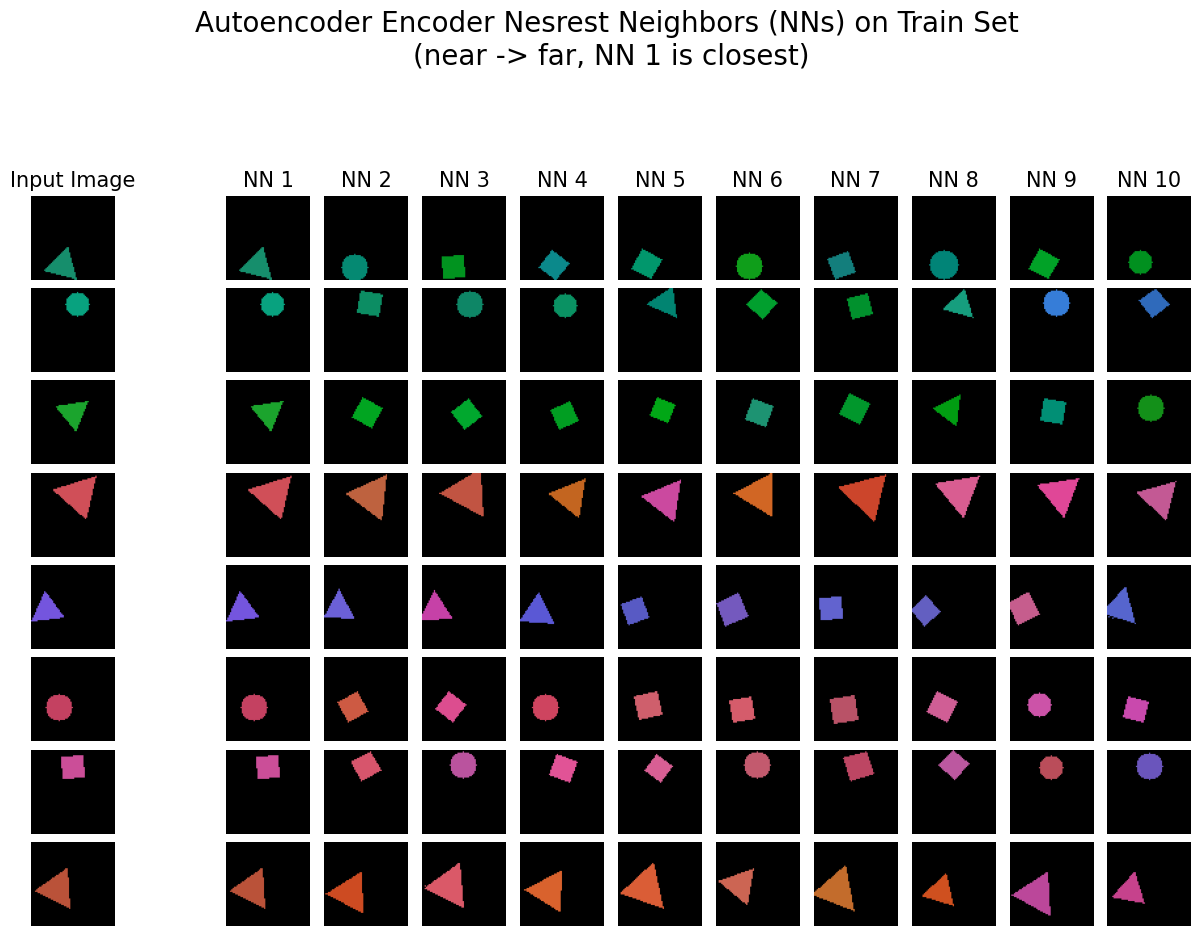

In [9]:
fig = nn_visualize(Dataset('train'), ae_enc, desc='Autoencoder Encoder')

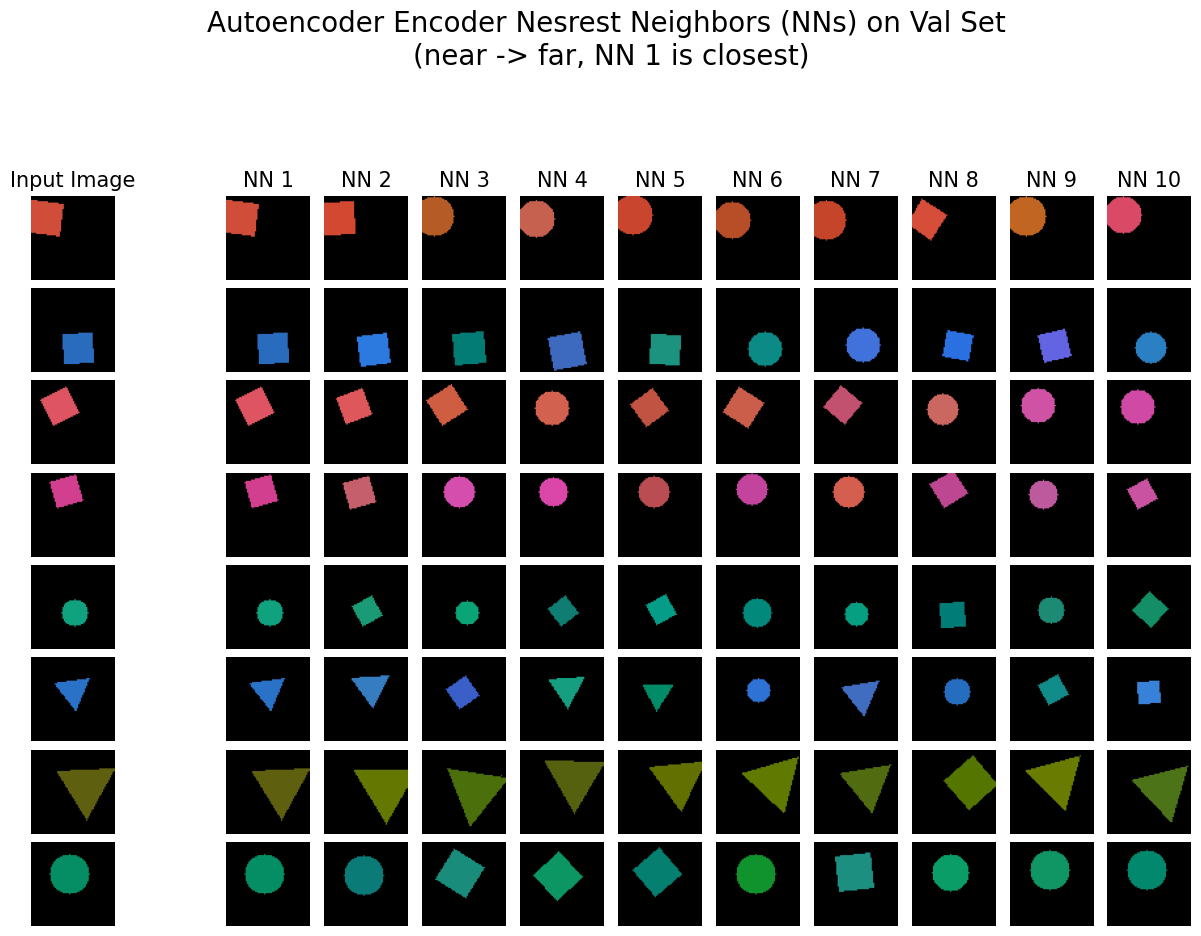

In [10]:
fig = nn_visualize(Dataset('val'), ae_enc, desc='Autoencoder Encoder')

# Contrastive Learning

Implement the following cross-entroy contrastive loss:

$$\mathcal{L}_\mathsf{contr}(f; \tau) = \mathbb{E}_{\substack{(x, x^+) \sim p_{\mathsf{positive}} \\(y^{\_}_1, \dots, y^{\_}_K) \overset{iid}{\sim} \mathsf{dataset}}}\bigg[ %
    - \log \frac{e^{f(x)^T f(x^+) / \tau}}{e^{f(x)^T f(x^+) / \tau} + \sum_{k=1}^K e^{f(x)^T f(y^-_k) / \tau}}%
\bigg],\qquad f\colon \mathsf{data} → \mathbb{S}^{d-1},\qquad \tau > 0.$$

Notable things about implementation:
1. Encoder $f$ is required to output $l_2$-normalized feature vectors. To implement this, we set the `normalize=True` flag in `Encoder`.
2. $\tau$ is a (fixed) temperature hyperparameter. In our code, we set it to 0.07, which is a common choice. (Usually $\tau \in [0.05, 0.3]$.)
3. As common in image contrastive learning, the positive pairs $p_\mathsf{positive}$ are defined as two random transformed versions of the **same** underlying data sample, where the negative samples are random transforms of **different** data samples. This is implemented by using random augmentations in the `transform=` argument of `Dataset`.
3. To efficiently sample features of negative pairs, we do not independently sample negatives for each positive pair. Instead, we only fetch a batch of positive pairs:

  $$\mathbf{x} \textsf{ of shape } [\underbrace{b}_{{\textsf{batch size}}} \times \underbrace{3 \times 64 \times 64}_{\textsf{image sample shape}}]$$
  $$\mathbf{x}^+ \textsf{ of shape } [b \times 3 \times 64 \times 64],$$

  where for each $\mathbf{x}[i]$,
  + $(\mathbf{x}[i], \mathbf{x}^+[i])$ forms **the** positive pair <br/>
     (i.e., two random augmentations of the same underlying image).
  + For $j \neq i$, $(\mathbf{x}[i], \mathbf{x}^+[j])$ form the $\mathbf{(b-1)}$ negative pairs.

  (You can verify that this, in expectation, computes the contrastive loss above exactly.)

  This means that, for encoded latents $$f(\mathbf{x}) \in \mathbb{R}^{b \times d_z} \text{ and } f(\mathbf{x}^+) \in \mathbb{R}^{b \times d_z},$$
  the logits (i.e., pairwise dot products) can be efficiently computed using a single matrix multiplication.

---

**Question 8a:** **Understand** the provided code in `train_contrastive`. Implement the FIXME that computes MSE reconstruction loss within 5 lines of code. Attach your code to write-up.

In [11]:
import einops
def train_contrastive(transforms: List, latent_dim: int, *, tau: float = 0.07):
    r'''
    Train encoder with `latent_dim` latent dimensions according
    to the **contrastive** objective described above using temperature
    `tau`.

    Implementation should follow notes above (including negative sampling
    from batch).

    The postive pairs are generated using random augmentations
    specified in `transform`.

    Returns the trained encoder.
    '''

    enc = Encoder(latent_dim, normalize=True).to(device)

    optim = torch.optim.Adam(enc.parameters(), lr=2e-4)

    dataset = Dataset('train', torchvision.transforms.Compose(transforms), num_samples=2)
    print('Visualize dataset')
    display.display(dataset.visualize(1, 10)); plt.close('all')
    display.display(dataset.visualize(2, 10)); plt.close('all')
    display.display(dataset.visualize(4, 10)); plt.close('all')
    display.display(dataset.visualize(5, 10)); plt.close('all')
    display.display(dataset.visualize(12, 10)); plt.close('all')
    display.display(dataset.visualize(15, 10)); plt.close('all')

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, pin_memory=True)
    num_epochs = 15

    for epoch in range(num_epochs):
        for batch1, batch2 in tqdm(dataloader, desc=f'Epoch {epoch} / {num_epochs}'):
            batch1 = batch1.to(device)
            batch2 = batch2.to(device)
            # batch1: a batched image tensor of shape [B x 3 x 64 x 64]
            # batch2: a batched image tensor of shape [B x 3 x 64 x 64]

            # For each i, p
            #   Positive pairs are (batch1[i], batch2[i])
            #   Negative pairs are (batch1[i], batch2[j]), j != i.
            x1 = enc(batch1)
            x2 = enc(batch2)
            assert x1.shape == x2.shape
            assert len(x1.shape) == 2
            
            # matmul does the work of everything we need, though we have done some of these twice
            loss_table = einops.einsum(x1, x2, 'batch1 dim, batch2 dim -> batch1 batch2')
            loss_table = torch.exp(loss_table / tau) # get all the exponentials
            loss_table = loss_table / loss_table.sum(dim=-1) # normalize the rows - softmax
            
            # FIXED
            loss = -torch.mean(torch.log(loss_table.diagonal())) # each of b gets b-1 negative and 1 positive => 1 term over b items

            optim.zero_grad()
            loss.backward()
            optim.step()
        print(f'[Contrastive] epoch {epoch: 4d}   loss = {loss.item():.4g}')

    return enc

## Augmentation A

Visualize augmentation A


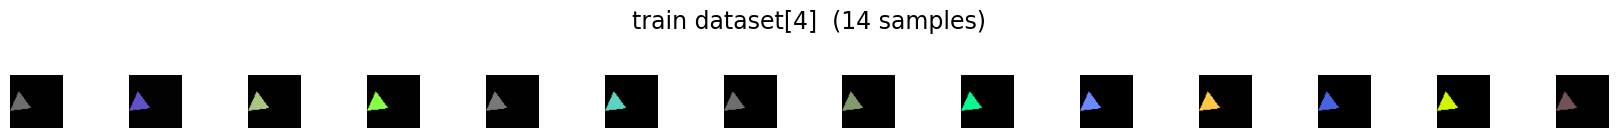

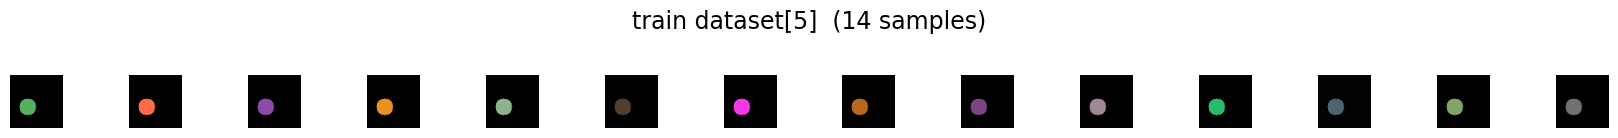

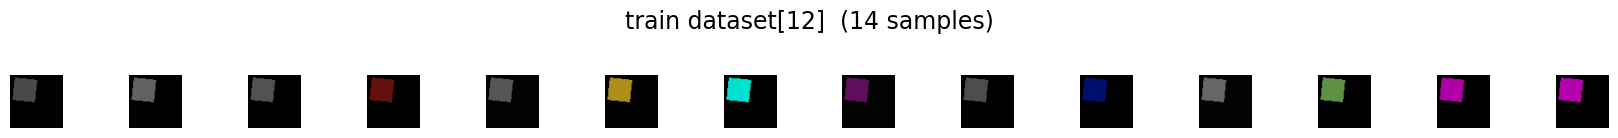

In [24]:
aug_A = [
    torchvision.transforms.RandomGrayscale(p=0.2),
    torchvision.transforms.ColorJitter(hue=.5, brightness=0.3, contrast=0.3, saturation=0.9),
]

dataset = Dataset('train', torchvision.transforms.Compose(aug_A), num_samples=2)
print('Visualize augmentation A')
for idx in [4, 5, 12]:
    _ = dataset.visualize(idx, 14)

## Augmentation B

Visualize augmentation B


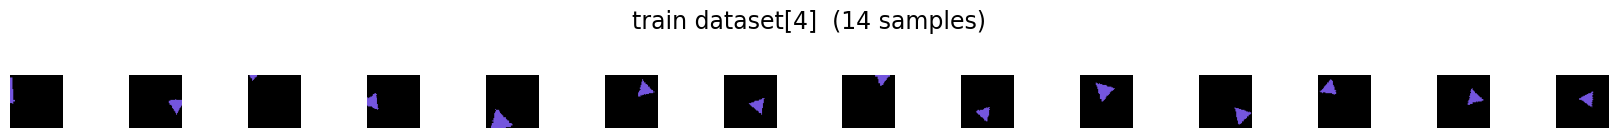

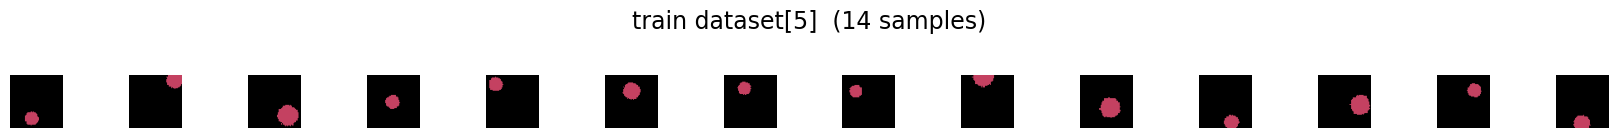

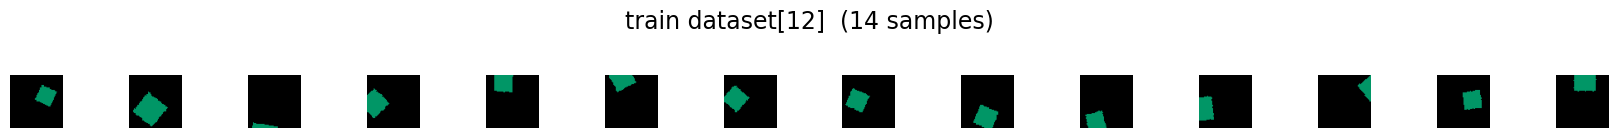

In [25]:
interpolation = torchvision.transforms.InterpolationMode.NEAREST
aug_B = [
    torchvision.transforms.Pad(24),
    torchvision.transforms.RandomRotation(degrees=(0, 360)),
    torchvision.transforms.RandomResizedCrop([64, 64], scale=(0.2, 0.6), ratio=(1, 1), interpolation=interpolation),
]


dataset = Dataset('train', torchvision.transforms.Compose(aug_B), num_samples=2)
print('Visualize augmentation B')
for idx in [4, 5, 12]:
    _ = dataset.visualize(idx, 14)

## Augmentation C

Visualize augmentation C


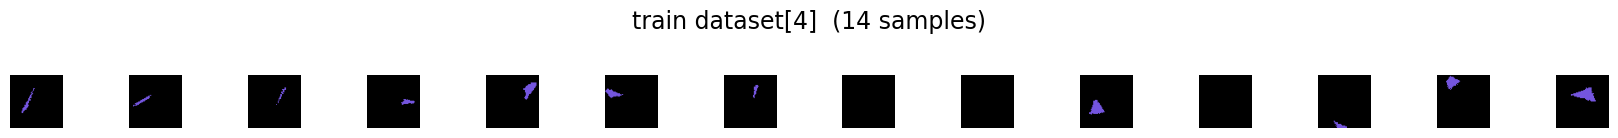

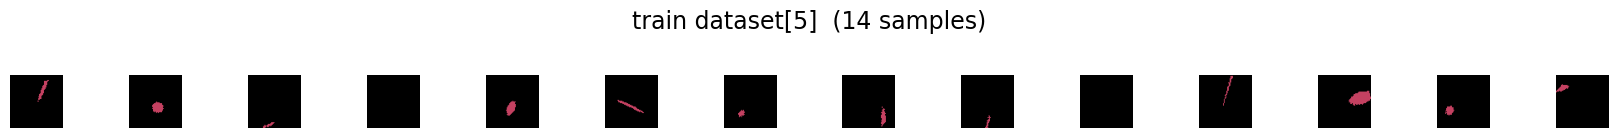

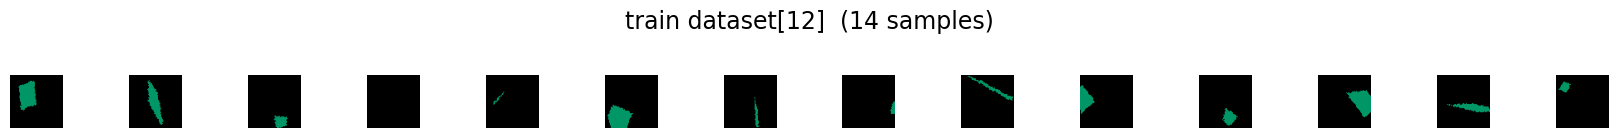

In [26]:
interpolation = torchvision.transforms.InterpolationMode.NEAREST
aug_C = [
    torchvision.transforms.Pad(16),
    torchvision.transforms.RandomRotation(degrees=(0, 360)),
    torchvision.transforms.RandomApply(
        [
            torchvision.transforms.RandomAffine(degrees=0, translate=(0.3, 0.3), shear=(-80, 80, -80, 80), interpolation=interpolation),
            torchvision.transforms.RandomPerspective(distortion_scale=0.6,  p=1, interpolation=interpolation),
        ],
        p=0.7,
    ),
    torchvision.transforms.RandomResizedCrop([64, 64], scale=(0.4, 0.8), ratio=(0.2, 5), interpolation=interpolation),
    torchvision.transforms.RandomRotation(degrees=(0, 360)),
]


dataset = Dataset('train', torchvision.transforms.Compose(aug_C), num_samples=2)
print('Visualize augmentation C')
for idx in [4, 5, 12]:
    _ = dataset.visualize(idx, 14)

## Train Encoders


**Question 8b:** Run the provided code in following cells to train three contrastive encoders on three different augmentation choices, and visualize the nearest neighbors for each.

In [27]:
# Each epoch will take around 2min (15 epochs in total).
from pathlib import Path
contrastive_enc_aug_A = None
checkpoint_path_A = Path('/mnt/align3_drive/adrianoh/dl-pset4/models/contrastive_enc_aug_A.pth')
if checkpoint_path_A.exists():
    state_dict = torch.load(checkpoint_path_A)
    contrastive_enc_aug_A = Encoder(128, normalize=True).cpu()
    contrastive_enc_aug_A.load_state_dict(state_dict)
    contrastive_enc_aug_A = contrastive_enc_aug_A.to(device)
    print('Loaded checkpoint')
else:
    print('Training contrastive encoder for augmentation A')
    contrastive_enc_aug_A = train_contrastive(transforms=aug_A, latent_dim=128)
    torch.save(contrastive_enc_aug_A.state_dict(), checkpoint_path_A)
assert contrastive_enc_aug_A is not None

Loaded checkpoint


/tmp/ipykernel_1969239/1288346970.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path_A)


In [28]:
# Each epoch will take around 2min (15 epochs in total).
from pathlib import Path
contrastive_enc_aug_B = None
checkpoint_path_B = Path('/mnt/align3_drive/adrianoh/dl-pset4/models/contrastive_enc_aug_B.pth')
if checkpoint_path_B.exists():
    state_dict = torch.load(checkpoint_path_B)
    contrastive_enc_aug_B = Encoder(128, normalize=True).cpu()
    contrastive_enc_aug_B.load_state_dict(state_dict)
    contrastive_enc_aug_B = contrastive_enc_aug_B.to(device)
    print('Loaded checkpoint')
else:
    print('Training contrastive encoder for augmentation B')
    contrastive_enc_aug_B = train_contrastive(transforms=aug_B, latent_dim=128)
    torch.save(contrastive_enc_aug_B.state_dict(), checkpoint_path_B)
assert contrastive_enc_aug_B is not None
for (pname1, p1), (pname2, p2) in zip(contrastive_enc_aug_A.named_parameters(), contrastive_enc_aug_B.named_parameters()):
    assert pname1 == pname2
    assert not torch.allclose(p1, p2)

Loaded checkpoint


/tmp/ipykernel_1969239/3809378574.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path_B)


In [29]:
# Each epoch will take around 2min (15 epochs in total).
from pathlib import Path
contrastive_enc_aug_C = None
checkpoint_path_C = Path('/mnt/align3_drive/adrianoh/dl-pset4/models/contrastive_enc_aug_C.pth')
if checkpoint_path_C.exists():
    state_dict = torch.load(checkpoint_path_C)
    contrastive_enc_aug_C = Encoder(128, normalize=True).cpu()
    contrastive_enc_aug_C.load_state_dict(state_dict)
    contrastive_enc_aug_C = contrastive_enc_aug_C.to(device)
    print('Loaded checkpoint')
else:
    print('Training contrastive encoder for augmentation C')
    contrastive_enc_aug_C = train_contrastive(transforms=aug_C, latent_dim=128)
    torch.save(contrastive_enc_aug_C.state_dict(), checkpoint_path_C)
assert contrastive_enc_aug_C is not None
for (pname1, p1), (pname2, p2), (pname3, p3) in zip(contrastive_enc_aug_A.named_parameters(), contrastive_enc_aug_B.named_parameters(), contrastive_enc_aug_C.named_parameters()):
    assert pname1 == pname2 == pname3
    assert not torch.allclose(p1, p2)
    assert not torch.allclose(p1, p3)
    assert not torch.allclose(p2, p3)

Loaded checkpoint


/tmp/ipykernel_1969239/2150247228.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path)


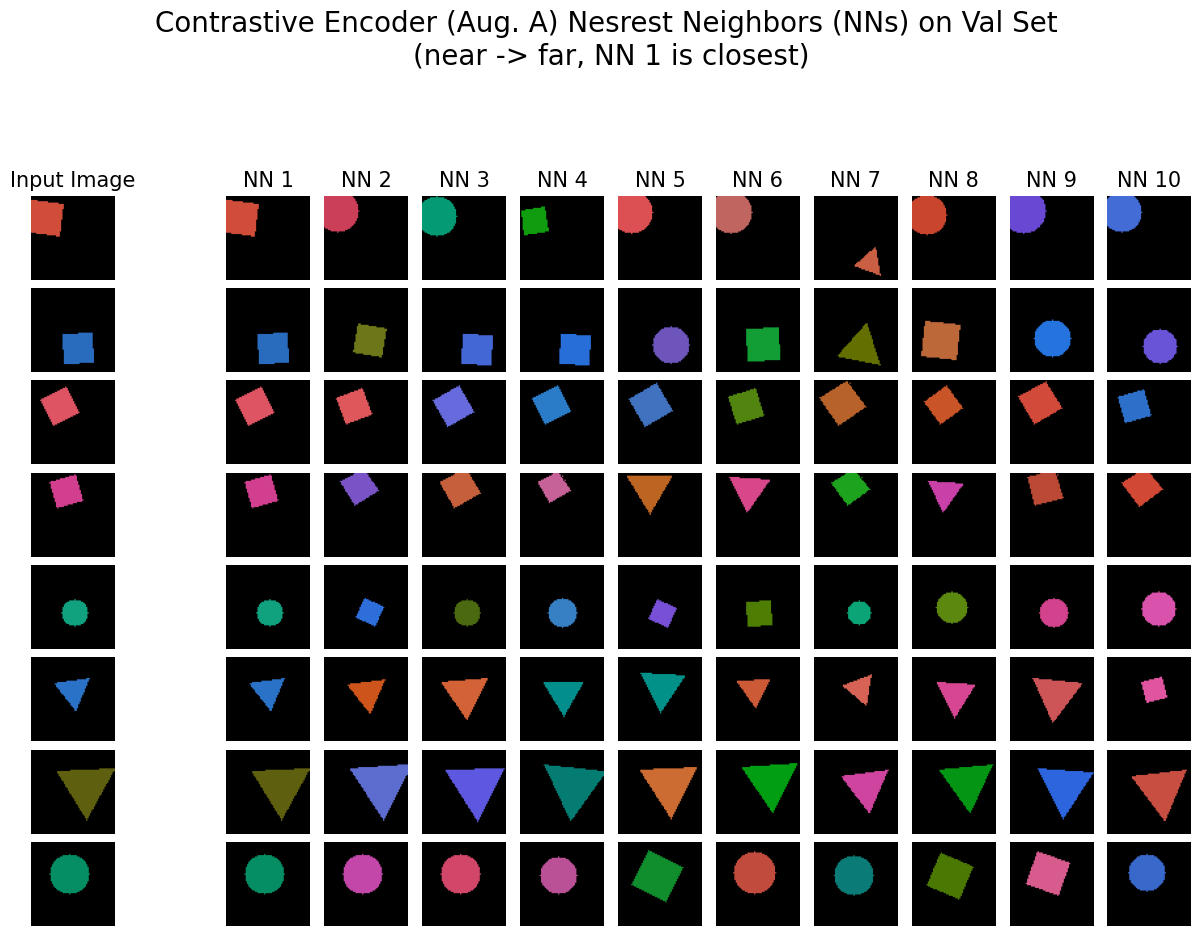

In [30]:
_ = nn_visualize(Dataset('val'), contrastive_enc_aug_A, desc='Contrastive Encoder (Aug. A)')

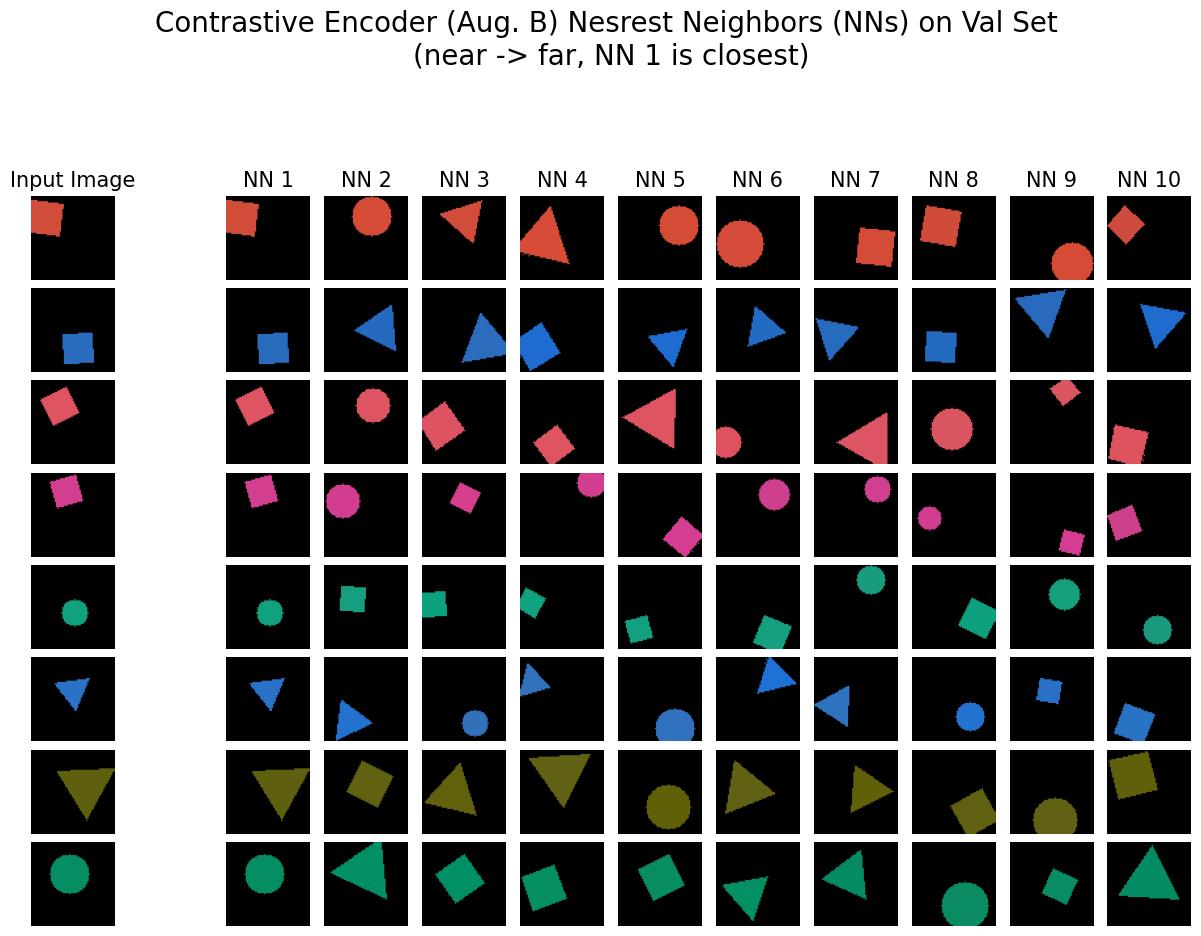

In [31]:
_ = nn_visualize(Dataset('val'), contrastive_enc_aug_B, desc='Contrastive Encoder (Aug. B)')

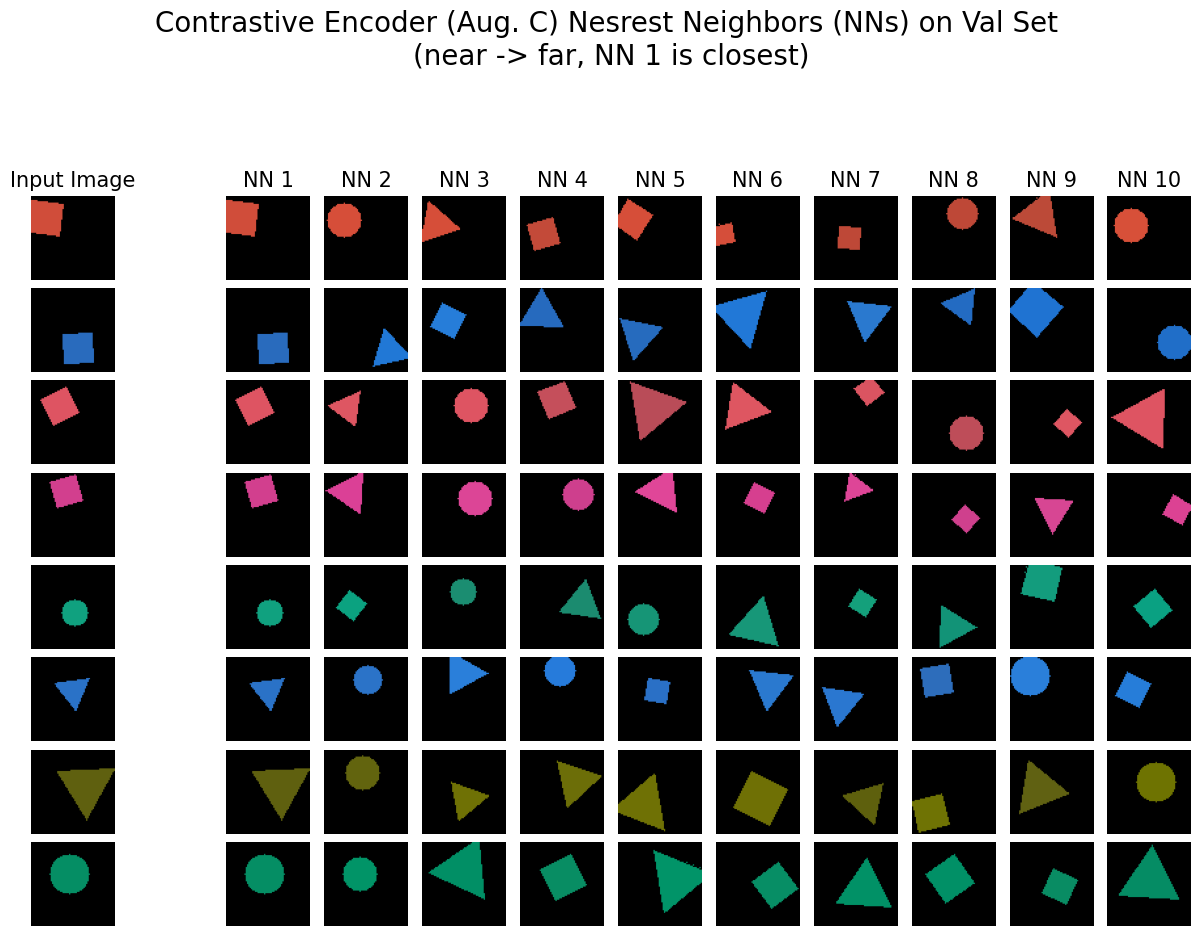

In [32]:
_ = nn_visualize(Dataset('val'), contrastive_enc_aug_C, desc='Contrastive Encoder (Aug. C)')